<a href="https://colab.research.google.com/github/AnitaKirkovska/Machine_Learning_Class/blob/master/HW3/VGG19_Data_Aug_Feature_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Downloading**

In [0]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip
  

--2019-04-16 17:19:14--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 2a00:1450:4013:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  60.4MB/s    in 1.1s    

2019-04-16 17:19:15 (60.4 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')

train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')

validation_dogs_dir = os.path.join(validation_dir, 'dogs')


**VGG**

In [0]:
from keras.applications import VGG19

conv_base = VGG19(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
80142336/80134624 [==============================] - 3s 0us/step


In [0]:
conv_base.trainable = False

**Merge**

In [0]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
# no dropout
model.add(layers.Dense(1, activation='sigmoid'))

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 22,122,049
Trainable params: 2,097,665
Non-trainable params: 20,024,384
_________________________________________________________________


**Frozen Conv Base**

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# compile model

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=2e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
100/100 [==============================] - 24s 236ms/step - loss: 0.6170 - acc: 0.6620 - val_loss: 0.4850 - val_acc: 0.7960
Epoch 2/30
100/100 [==============================] - 20s 195ms/step - loss: 0.5196 - acc: 0.7535 - val_loss: 0.4139 - val_acc: 0.8280
Epoch 3/30
100/100 [==============================] - 18s 184ms/step - loss: 0.4682 - acc: 0.7900 - val_loss: 0.3675 - val_acc: 0.8300
Epoch 4/30
100/100 [==============================] - 18s 181ms/step - loss: 0.4494 - acc: 0.8020 - val_loss: 0.3488 - val_acc: 0.8380
Epoch 5/30
100/100 [==============================] - 18s 181ms/step - loss: 0.4240 - acc: 0.8065 - val_loss: 0.3588 - val_acc: 0.8540
Epoch 6/30
100/100 [==============================] - 19s 193ms/step - loss: 0.4110 - acc: 0.8150 - val_loss: 0.3242 - val_acc: 0.8480
Epoch 7/30
100/100 [==============================] - 18s 

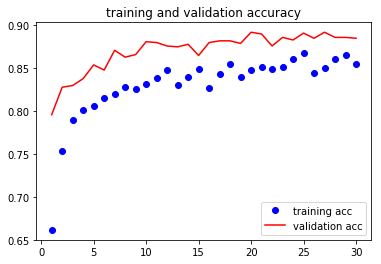

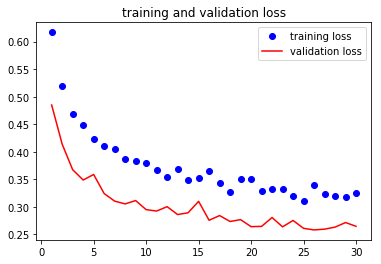

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'r', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'r', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

**Val Loss and Accuracy**

In [0]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)

In [0]:
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Validation loss: 0.25099982529878617
Validation accuracy: 0.8889999985694885
